![image](https://user-images.githubusercontent.com/20357655/145710301-ad00ab66-2378-404f-a918-576aba834ff9.png)

In this homework, we will try to implement a `View Synthesis` model that allows us to generate new scene views based on a single image.

The basic idea is to use `differentiable point cloud rendering`, which is used to convert a hidden 3D feature point cloud into a target view.
The projected features are decoded by `refinement network` to inpaint missing regions and generate a realistic output image.

### Overall pipeline disribed below

![image](https://user-images.githubusercontent.com/20357655/145710444-0d0e163f-6996-4eb8-81c0-69798b11c5a6.png)

# Data
## Download KITTI dataset

In [1]:
! wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework04/gfile.py
! wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework04/kitti.py

--2022-05-14 07:33:19--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework04/gfile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3423 (3.3K) [text/plain]
Saving to: ‘gfile.py’

gfile.py            100%[===================>]   3.34K  --.-KB/s    in 0s      

2022-05-14 07:33:19 (51.3 MB/s) - ‘gfile.py’ saved [3423/3423]

--2022-05-14 07:33:19--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework04/kitti.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

 ``` python 
 from gfile import download_file_from_google_drive
 
 download_file_from_google_drive(
    '1lqspXN10biBShBIVD0yvgnl1nIPPhRdC',
     'kitti.zip'
 )
```
Optionally you can download with native gdown

``` sh
    gdown --id 1lqspXN10biBShBIVD0yvgnl1nIPPhRdC
```

In [ ]:
# ! unzip dataset_kitti.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1lqspXN10biBShBIVD0yvgnl1nIPPhRdC 

unzip:  cannot find or open dataset_kitti.zip, dataset_kitti.zip.zip or dataset_kitti.zip.ZIP.


#### pytorch3d installation

The pytorch3d library needed to work with geometry. We highly encourage to see on the https://pytorch3d.org/tutorials/

To give you hints we provide some snipets, that can work at colab (deends from the overal environment).



In [2]:
# If you version is low enough, you will not have problems
# optionally you can downgrade pytorch and use native installation with the following line
import torch

if torch.__version__.startswith("1.11."):
  !pip3 install torch==1.10.2+cu113  torchvision==0.11.3+cu113  -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:34tcmalloc: large alloc 1147494400 bytes == 0x38e02000 @  0x7f24de9aa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████▌             | 1055.7 MB 1.5 MB/s eta 0:08:48tcmalloc: large alloc 1434370048 bytes == 0x7d458000 @  0x7f24de9aa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████████████▌        | 1336.2 MB 1.4 MB/s eta 0:05:51tcmalloc: large alloc 1792966656 bytes =

In [3]:

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   621k      0 --:--:-- --:--:-- --:--:--  621k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-8icu7gvj
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-8icu7gvj
  Running command git checkout -q 2bd65027ca5c3b87b77d4f05b8eacae58d8d106f
     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 26.8 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.2-cp37-cp37m-linux_x86_64.whl size=30777687 sha256=a61479c14679dac40f94d73ce37178a8276e89427e1373e4afbdd6d79b304e12
  Stored in directory: /tmp/pip-ephem-wheel-cache-3akeny2x/wheels/4c/03/f0/326bb241eb86a155a12f217c81e16

## Dataset

In [1]:
%pylab inline

from tqdm import tqdm
from itertools import islice
from IPython.display import clear_output, HTML
from collections import defaultdict

from kitti import KITTIDataLoader

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

import torchvision

from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import PerspectiveCameras, compositing, rasterize_points

Populating the interactive namespace from numpy and matplotlib


In [2]:
def split_RT(RT):
    return RT[..., :3, :3], RT[..., :3, 3]

def renormalize_image(image):
    return image * 0.5 + 0.5

In [3]:
#  from gfile import download_file_from_google_drive

#  download_file_from_google_drive(
#     '1lqspXN10biBShBIVD0yvgnl1nIPPhRdC',
#      'kitti.zip'
#  )
!gdown 1mxti82O3dxuA4eqIFPYMTmQGH-3q2XfX
!unzip dataset_kitti.zip
# !ls

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: dataset_kitti/images/08_001864.png  
 extracting: dataset_kitti/images/08_001865.png  
 extracting: dataset_kitti/images/08_001866.png  
 extracting: dataset_kitti/images/08_001867.png  
 extracting: dataset_kitti/images/08_001868.png  
 extracting: dataset_kitti/images/08_001869.png  
 extracting: dataset_kitti/images/08_001870.png  
 extracting: dataset_kitti/images/08_001871.png  
 extracting: dataset_kitti/images/08_001872.png  
 extracting: dataset_kitti/images/08_001873.png  
 extracting: dataset_kitti/images/08_001874.png  
 extracting: dataset_kitti/images/08_001875.png  
 extracting: dataset_kitti/images/08_001876.png  
 extracting: dataset_kitti/images/08_001877.png  
 extracting: dataset_kitti/images/08_001878.png  
  inflating: dataset_kitti/images/08_001879.png  
 extracting: dataset_kitti/images/08_001880.png  
 extracting: dataset_kitti/images/08_001881.png  
 extracting: dataset_kitti/image

In [4]:
dataset = KITTIDataLoader('dataset_kitti')

Each instance of dataset contain `source` and `target` images, `extrinsic` and `intrinsic` camera parameters for `source` and `targer` images.

It is highly recommended to understand these concepts, e.g., here https://ksimek.github.io/2012/08/22/extrinsic/

In [5]:
images, cameras = dataset[0].values()

(-0.5, 255.5, 255.5, -0.5)

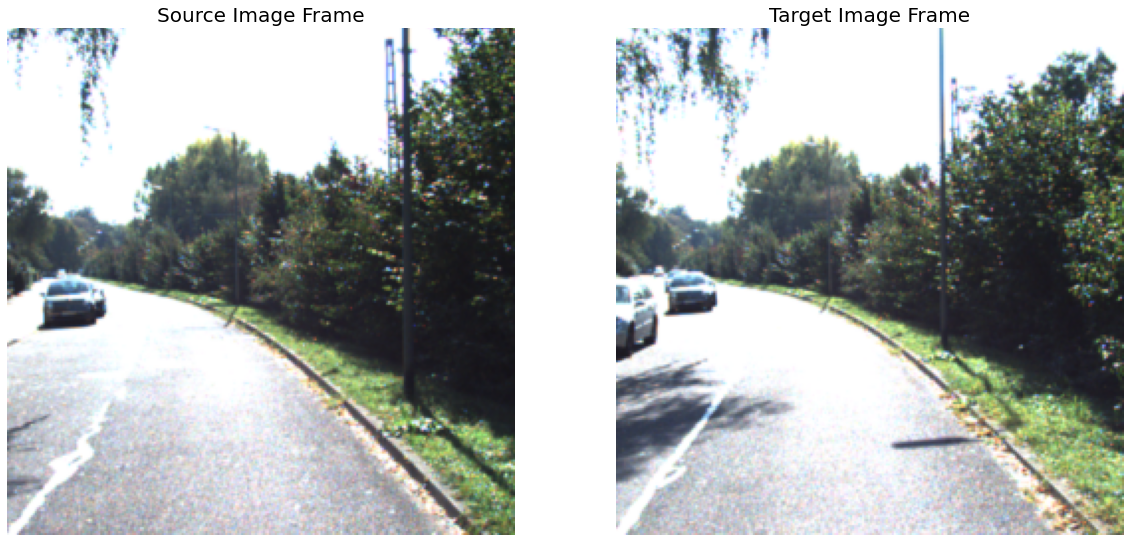

In [ ]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
ax.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)
ax.set_title('Source Image Frame', fontsize=20)
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(images[1].permute(1, 2, 0) * 0.5 + 0.5)
ax.set_title('Target Image Frame', fontsize=20)
ax.axis('off')

In [ ]:
source_camera = PerspectiveCameras(
    R=split_RT(cameras[0]['P'])[0][None],
    T=split_RT(cameras[0]['P'])[1][None],
    K=torch.from_numpy(cameras[0]['K'])[None]
)

target_camera = PerspectiveCameras(
    R=split_RT(cameras[1]['P'])[0][None],
    T=split_RT(cameras[1]['P'])[1][None],
    K=torch.from_numpy(cameras[1]['K'])[None]
)

plot_scene(
    {
        'scene': {
            'source_camera': source_camera,
            'target_camera': target_camera
        }
    },
)

In [6]:
indexes = torch.randperm(len(dataset))

train_indexes = indexes[:-1000]
validation_indexes = indexes[-1000:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

train_dataloader = DataLoader(
    train_dataset, batch_size=16, num_workers=2,
    shuffle=True, drop_last=True, pin_memory=True
)
validation_dataloder = DataLoader(
    validation_dataset, batch_size=10, num_workers=2,
    pin_memory=True
)

---

# Models
Our main task here is to understand the simple way to solve novel view synthesis problem from single image.
We need to implement `Spatial Feature Predictor`, `Depth Regressor`, `Point Cloud Renderer` and `RefinementNetwork`.

One of the main building blocks in these networks is `ResNetBlock`, but with some modifications:

![image](https://user-images.githubusercontent.com/20357655/145711537-eebb0cb9-8935-4d65-bc4b-559c1e19ba98.png)

So, let's implement it, but without the noise part `Linear + z`

In [7]:
class ResNetBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        mode = 'identity'
    ):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.identity_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
        if mode == 'identity':
            self.identity_upsample = nn.Identity()
        elif mode == 'up':
            self.identity_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        elif mode == 'down':
            self.identity_upsample = nn.AvgPool2d(kernel_size=2)
    
    def forward(self, input):
        identity = input

        out = self.bn1(input)
        out = self.activation(out)
        out = self.identity_upsample(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv2(out)

        identity = self.identity_upsample(identity)
        identity = self.identity_conv(identity)
        out += identity

        return out

## Spatial Feature Predictor

![image](https://user-images.githubusercontent.com/20357655/145711931-be08e4f9-f383-4942-8b93-f8bdfd3060d2.png)

In [8]:
class SpatialFeatureNetwork(nn.Module):
    
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.blocks = nn.Sequential(
            # TODO
            ResNetBlock(in_channels, out_channels // 4),
            ResNetBlock(out_channels // 4, out_channels // 4),
            ResNetBlock(out_channels // 4, out_channels // 4),
            ResNetBlock(out_channels // 4, out_channels // 2),
            ResNetBlock(out_channels // 2, out_channels // 2),
            ResNetBlock(out_channels // 2, out_channels // 2),
            ResNetBlock(out_channels // 2, out_channels // 2),
            ResNetBlock(out_channels // 2, out_channels)
        )

    def forward(self, input: torch.Tensor):
        return self.blocks(input)

sf_net = SpatialFeatureNetwork()

test_in = torch.rand(2, 3, 100, 100) 
test_out = sf_net(test_in)
assert list(test_out.shape) == [2, 64, 100, 100], test_out.shape
assert len(sf_net.blocks) == 8, len(sf_net.blocks)

## Depth Regressor

![image](https://user-images.githubusercontent.com/20357655/145711785-690008e5-96d0-418f-adf1-1509e399c92e.png)

A green convolution has parameters: stride 2, padding 1, kernel size 4.

An `Enc Block` consists of a sequence of Leaky ReLU, convolution (stride 2, padding 1, kernel size 4), and batch normalisation layers.

A `Dec Block` consists of a sequence of ReLU, 2x bilinear upsampling, convolution (stride 1, padding 1, kernel size3), and batch normalisation layers (except for the final layer, which has no batch normalisation layer).

In [9]:
from re import X

# TODO class EncoderBlock
class EncoderBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.blocks = nn.Sequential(
            # TODO
            nn.LeakyReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, input):
        return self.blocks(input)

test_input = torch.randn(2, 64, 128, 128)
encoder = EncoderBlock(64, 128)
assert list(encoder(test_input).shape) == [2, 128, 64, 64], encoder(test_input).shape

# TODO class DecoderBlock
class DecoderBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, batch_norm=True):
        super().__init__()
        self.batch_norm = batch_norm
        self.blocks = nn.Sequential(
            # TODO
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        output = self.blocks(input)
        if self.batch_norm:
            output = self.bn(output)
        return output

decoder = DecoderBlock(64, 32)
assert list(decoder(test_input).shape) == [2, 32, 256, 256], decoder(test_input).shape

class Unet(nn.Module):
    def __init__(
        self,
        num_filters=32,
        channels_in=3,
        channels_out=3
    ):
        super(Unet, self).__init__()
        self.encoder = nn.ModuleList([
            #TODO
            nn.Conv2d(channels_in, num_filters, kernel_size=4, stride=2, padding=1),
            EncoderBlock(num_filters, num_filters * 2),
            EncoderBlock(num_filters * 2, num_filters * 4),
            EncoderBlock(num_filters * 4, num_filters * 8),
            EncoderBlock(num_filters * 8, num_filters * 8),
            EncoderBlock(num_filters * 8, num_filters * 8),
            EncoderBlock(num_filters * 8, num_filters * 8),
            EncoderBlock(num_filters * 8, num_filters * 8)
        ])
        self.decoder = nn.ModuleList([
            #TODO
            DecoderBlock(num_filters * 8, num_filters * 8),
            DecoderBlock(num_filters * 8 * 2, num_filters * 8),
            DecoderBlock(num_filters * 8 * 2, num_filters * 8),
            DecoderBlock(num_filters * 8 * 2, num_filters * 8),
            DecoderBlock(num_filters * 8 * 2, num_filters * 4),
            DecoderBlock(num_filters * 4 * 2, num_filters * 2),
            DecoderBlock(num_filters * 2 * 2, num_filters),
            
        ])
        self.final_layer = DecoderBlock(num_filters * 2, channels_out, batch_norm=False)
        self.tanh = nn.Tanh()

    def forward(self, input):
      # TODO  x in [-1, 1]
      enc1 = self.encoder[0](input)
      enc2 = self.encoder[1](enc1)
      enc3 = self.encoder[2](enc2)
      enc4 = self.encoder[3](enc3)
      enc5 = self.encoder[4](enc4)
      enc6 = self.encoder[5](enc5)
      enc7 = self.encoder[6](enc6)
      enc8 = self.encoder[7](enc7)

      dec1 = self.decoder[0](enc8)
      dec1 = torch.cat([dec1, enc7], dim=1)
      dec2 = self.decoder[1](dec1)
      dec2 = torch.cat([dec2, enc6], dim=1)
      dec3 = self.decoder[2](dec2)
      dec3 = torch.cat([dec3, enc5], dim=1)
      dec4 = self.decoder[3](dec3)
      dec4 = torch.cat([dec4, enc4], dim=1)
      dec5 = self.decoder[4](dec4)
      dec5 = torch.cat([dec5, enc3], dim=1)
      dec6 = self.decoder[5](dec5)
      dec6 = torch.cat([dec6, enc2], dim=1)
      dec7 = self.decoder[6](dec6)
      dec7 = torch.cat([dec7, enc1], dim=1)

      output = self.final_layer(dec7)
      x = self.tanh(output)

      return x

unet = Unet()
test_input = torch.randn(2, 3, 512, 512)
assert unet(test_input).shape == test_input.shape, unet(test_input).shape

## Refinement Network

![image](https://user-images.githubusercontent.com/20357655/145711921-45ebf1e5-e852-4c47-8b93-d545f67dc6bf.png)

In [10]:
class RefinementNetwork(nn.Module):
    def __init__(self, in_channels=64, out_channels=3):
        super().__init__()
        self.blocks = nn.Sequential(
            # TODO
            ResNetBlock(in_channels, in_channels // 2),
            ResNetBlock(in_channels // 2, in_channels * 2, mode='down'),
            ResNetBlock(in_channels * 2, in_channels * 2, mode='down'),
            ResNetBlock(in_channels * 2, in_channels),
            ResNetBlock(in_channels, in_channels, mode='up'),
            ResNetBlock(in_channels, in_channels, mode='up'),
            ResNetBlock(in_channels, in_channels),
            ResNetBlock(in_channels, out_channels)
            
        )
    
    def forward(self, input: torch.Tensor):
        return self.blocks(input)

test_input = torch.randn(2, 64, 128, 128)
rn = RefinementNetwork()
assert list(rn(test_input).shape) == [2, 3, 128, 128], rn(test_input).shape

## Auxiliary network

In [11]:
class VGG19(nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = torchvision.models.vgg19(
            pretrained=True
        ).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Normalize the image so that it is in the appropriate range
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out

---

# Criterions & Metrics

In [12]:
class PerceptualLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Set to false so that this part of the network is frozen
        self.model = VGG19(requires_grad=False)
        self.criterion = nn.L1Loss()
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

    def forward(self, pred_img, gt_img):
        gt_fs = self.model(gt_img)
        pred_fs = self.model(pred_img)

        # Collect the losses at multiple layers (need unsqueeze in
        # order to concatenate these together)
        loss = 0
        for i in range(0, len(gt_fs)):
            loss += self.weights[i] * self.criterion(pred_fs[i], gt_fs[i])

        return loss


In [13]:
def psnr(predicted_image, target_image):
    batch_size = predicted_image.size(0)
    mse_err = (
        (predicted_image - target_image)
        .pow(2).sum(dim=1)
        .view(batch_size, -1).mean(dim=1)
    )

    psnr = 10 * (1 / mse_err).log10()
    return psnr.mean()

---

# Point Cloud Renderer

`Differential Rasterization` is a key component of our system. We will use the algorithm already implemented in `pytorch3d`.

![image](https://user-images.githubusercontent.com/20357655/145715968-94abbe1a-8d14-4c20-98c4-61afd9161ada.png)

For more details read (3.2) https://arxiv.org/pdf/1912.08804.pdf

In [14]:
class PointsRasterizerWithBlending(nn.Module):
    """
    Rasterizes a set of points using a differentiable renderer. 
    """

    def __init__(self, radius=1.5, image_size=256, points_per_pixel=8):
        super().__init__()

        self.radius = radius
        self.image_size = image_size
        self.points_per_pixel = points_per_pixel
        
        self.rad_pow = 2
        self.tau = 1.0

    def forward(self, point_cloud, spatial_features):
        batch_size = spatial_features.size(0)

        # Make sure these have been arranged in the same way
        assert point_cloud.size(2) == 3
        assert point_cloud.size(1) == spatial_features.size(2)

        point_cloud[:, :, 1] = -point_cloud[:, :, 1]
        point_cloud[:, :, 0] = -point_cloud[:, :, 0]

        radius = float(self.radius) / float(self.image_size) * 2.0

        point_cloud = Pointclouds(points=point_cloud, features=spatial_features.permute(0, 2, 1))
        points_idx, _, dist = rasterize_points(
            point_cloud, self.image_size, radius, self.points_per_pixel
        )

        dist = dist / pow(radius, self.rad_pow)

        alphas = (
            (1 - dist.clamp(max=1, min=1e-3).pow(0.5))
            .pow(self.tau)
            .permute(0, 3, 1, 2)
        )
    
        transformed_src_alphas = compositing.alpha_composite(
            points_idx.permute(0, 3, 1, 2).long(),
            alphas,
            point_cloud.features_packed().permute(1, 0),
        )

        return transformed_src_alphas

And `PointsManipulator` do the following steps:

    1) Create virtual image place in [normalized coordinate](https://pytorch3d.org/docs/cameras)
    2) Move camera according to `regressed depth`
    3) Rotate points according to target camera paramers
    4) And finally render them with help of `PointsRasterizerWithBlending`

In [15]:
class PointsManipulator(nn.Module):
    EPS = 1e-5

    def __init__(self, image_size):
        super().__init__()
        # Assume that image plane is square

        self.splatter = PointsRasterizerWithBlending(
            radius=1.0,
            image_size=image_size,
            points_per_pixel=128,
        )

        xs = torch.linspace(0, image_size - 1, image_size) / \
            float(image_size - 1) * 2 - 1
        ys = torch.linspace(0, image_size - 1, image_size) / \
            float(image_size - 1) * 2 - 1

        xs = xs.view(1, 1, 1, image_size).repeat(1, 1, image_size, 1)
        ys = ys.view(1, 1, image_size, 1).repeat(1, 1, 1, image_size)

        xyzs = torch.cat(
            (xs, -ys, -torch.ones(xs.size()), torch.ones(xs.size())), 1
        ).view(1, 4, -1)

        self.register_buffer("xyzs", xyzs)

    def project_pts(self, depth, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2):
        # Project the world points into the new view
        projected_coors = self.xyzs * depth
        projected_coors[:, -1, :] = 1

        # Transform into camera coordinate of the first view
        cam1_X = K_inv.bmm(projected_coors)

        # Transform into world coordinates
        RT = RT_cam2.bmm(RTinv_cam1)

        wrld_X = RT.bmm(cam1_X)

        # And intrinsics
        xy_proj = K.bmm(wrld_X)

        # And finally we project to get the final result
        mask = (xy_proj[:, 2:3, :].abs() < self.EPS).detach()

        # Remove invalid zs that cause nans
        zs = xy_proj[:, 2:3, :]
        zs[mask] = self.EPS

        sampler = torch.cat((xy_proj[:, 0:2, :] / -zs, xy_proj[:, 2:3, :]), 1)
        sampler[mask.repeat(1, 3, 1)] = -10
        # Flip the ys
        sampler = sampler * torch.Tensor([1, -1, -1]).unsqueeze(0).unsqueeze(
            2
        ).to(sampler.device)

        return sampler

    def forward_justpts(
        self,
        spatial_features, depth,
        K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
    ):
        # Now project these points into a new view
        batch_size, c, w, h = spatial_features.size()

        if len(depth.size()) > 3:
            # reshape into the right positioning
            depth = depth.view(batch_size, 1, -1)
            spatial_features = spatial_features.view(batch_size, c, -1)

        pointcloud = self.project_pts(
            depth, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
        )
        pointcloud = pointcloud.permute(0, 2, 1).contiguous()
        result = self.splatter(pointcloud, spatial_features)

        return result

---

# All together

In [28]:
class ViewSynthesisModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.spatial_feature_predictor = SpatialFeatureNetwork()
        self.depth_regressor = Unet(channels_in=3, channels_out=1)
        self.point_cloud_renderer = PointsManipulator(image_size=256)
        self.refinement_network = RefinementNetwork()

        # Special constant for KITTI dataset
        self.z_min = 1.0
        self.z_max = 50.0

    def forward(
        self,
        #TODO
        input,
        K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
    ):
        # TODO
        # 1) Predict spatial feature for source image
        features = self.spatial_feature_predictor(input)
        # 2) Predict depth for source image (dont forget to renormalize depth with z_min/z_max)
        regressed_depth = self.depth_regressor(input)
        regressed_depth = (regressed_depth + 1.) / 2. # 0..1
        regressed_depth = regressed_depth * (self.z_max - self.z_min) + self.z_min
        # 3) Generate new features with `point_cloud_renderer`
        new_features = self.point_cloud_renderer.forward_justpts(features, regressed_depth, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2)
        # 4) And finnaly apply `refinement_network` to obtain new image
        generated_image = self.refinement_network(new_features)
        # 5) return new image, and depth of source image
        return generated_image, regressed_depth

---

# Training

In order for the work to be accepted, you must achieve a quality of ~0.5 (validation loss value) and visualize several samples as in the example

In [29]:
device = torch.device('cuda')

model = ViewSynthesisModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
histoty = defaultdict(list)

l1_criterion = nn.L1Loss()
perceptual_criterion = PerceptualLoss().to(device)

In [30]:
indexes = torch.randperm(len(dataset))

train_indexes = indexes[:40]
validation_indexes = indexes[:40]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)



batch_size = 10
num_epochs = 100
val_batch_size = 4

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2,
    shuffle=True, drop_last=True, pin_memory=True
)
validation_dataloder = DataLoader(
    validation_dataset, batch_size=val_batch_size, num_workers=2,
    pin_memory=True
)

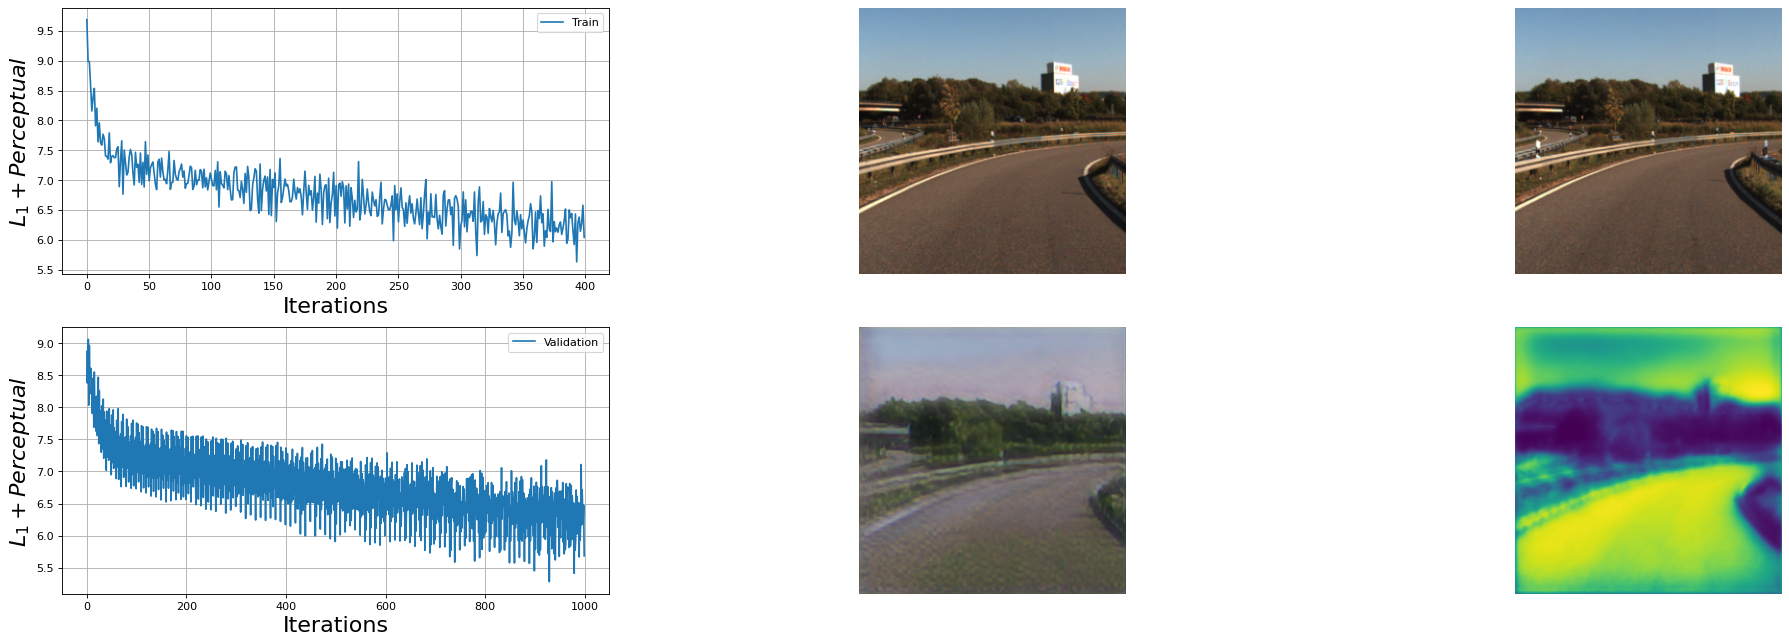

In [31]:
for epoch in range(num_epochs):
    for i, batch in tqdm(enumerate(train_dataloader, 2), total=len(train_dataloader)):
        source_image = batch["images"][0].to(device)
        target_image = batch["images"][-1].to(device)

        # TODO
        source_cameras = batch["cameras"][0]
        target_cameras = batch["cameras"][-1]
        K = source_cameras['K'].to(device)
        K_inv = source_cameras['Kinv'].to(device)
        RT_cam1 = source_cameras['P'].to(device)
        RTinv_cam1 = source_cameras['Pinv'].to(device)
        RT_cam2 = target_cameras['P'].to(device)
        RTinv_cam2 = target_cameras['Pinv'].to(device)

        generated_image, regressed_depth = model(source_image, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2)

        loss = l1_criterion(generated_image, target_image) \
            + 10 * perceptual_criterion(
            renormalize_image(generated_image),
            renormalize_image(target_image)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        histoty['train_loss'].append(loss.item())
    
    for i, batch in tqdm(enumerate(validation_dataloder), total=len(validation_dataloder)):
        source_image = batch["images"][0].to(device)
        target_image = batch["images"][-1].to(device)

        with torch.no_grad():
            # TODO
            source_cameras = batch["cameras"][0]
            target_cameras = batch["cameras"][-1]
            K = source_cameras['K'].to(device)
            K_inv = source_cameras['Kinv'].to(device)
            RT_cam1 = source_cameras['P'].to(device)
            RTinv_cam1 = source_cameras['Pinv'].to(device)
            RT_cam2 = target_cameras['P'].to(device)
            RTinv_cam2 = target_cameras['Pinv'].to(device)

            generated_image, regressed_depth = model(source_image, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2)

        loss = l1_criterion(generated_image, target_image) \
            + 10 * perceptual_criterion(
            renormalize_image(generated_image),
            renormalize_image(target_image)
        )

        histoty['validation_loss'].append(loss.item())
    
        
    clear_output()
    fig = plt.figure(figsize=(30, 15), dpi=80)
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(histoty['train_loss'], label='Train')
    ax1.set_xlabel('Iterations', fontsize=20)
    ax1.set_ylabel(r'${L_1} + Perceptual$', fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2 = plt.subplot(3, 3, 4)
    ax2.plot(histoty['validation_loss'], label='Validation')
    ax2.set_xlabel('Iterations', fontsize=20)
    ax2.set_ylabel(r'${L_1} + Perceptual$', fontsize=20)
    ax2.legend()
    ax2.grid()

    for index, image in zip(
      (2, 3, 5, 6),
      (source_image, target_image, generated_image, regressed_depth.repeat(1, 3, 1,1))
  ):
      ax = plt.subplot(3, 3, index)
      if index == 6:
          im = ax.imshow(image.detach().cpu()[0].permute(1, 2, 0)[...,0])
      else:
          im = ax.imshow(renormalize_image(image.detach().cpu()[0]).permute(1, 2, 0))
      ax.axis('off')

    plt.show()

# Visualize

Goes along depth and generate new views

In [32]:
RTs = []
for i in torch.linspace(0, 0.5, 40):
    current_RT = torch.eye(4).unsqueeze(0)
    current_RT[:, 2, 3] = i
    RTs.append(current_RT.to(device))
identity_matrx = torch.eye(4).unsqueeze(0).to(device)

In [33]:
random_instance_index = 12

with torch.no_grad():
    model.eval()
    images, cameras = validation_dataset[random_instance_index].values()
    # Input values
    input_img = images[0][None].cuda()

    # Camera parameters
    K = torch.from_numpy(cameras[0]["K"])[None].to(device)
    K_inv = torch.from_numpy(cameras[0]["Kinv"])[None].to(device)
    
    spatial_features = model.spatial_feature_predictor(input_img)
    regressed_depth = model.depth_regressor(input_img)
    regressed_depth = (regressed_depth + 1.) / 2. # 0..1
    regressed_depth = regressed_depth * (model.z_max - model.z_min) + model.z_min

    new_images = []
    for current_RT in RTs:
        generated_features = model.point_cloud_renderer.forward_justpts(
            spatial_features,
            regressed_depth,
            K,
            K_inv,
            identity_matrx,
            identity_matrx,
            current_RT,
            None
        )
        generated_image = model.refinement_network(generated_features)
        new_images.append(renormalize_image(generated_image.cpu()).clamp(0, 1).mul(255).to(torch.uint8))

In [34]:
to_img = lambda x: x[0].permute(1,2,0).numpy()
import cv2
# import torchvision
video_name = 'video.mp4'
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 20, (256, 256))

for frame in new_images:
    video.write(to_img(frame))

cv2.destroyAllWindows()
video.release()
# Alternatively
# frames = torch.cat(new_images).permute(0, 2, 3, 1)
# torchvision.io.write_video('video.mp4', frames, fps=20)


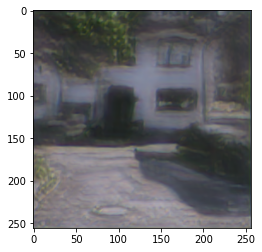

In [35]:
plt.imshow(to_img(frame))

In [24]:
HTML("""
    <video width="256" alt="test" controls>
        <source src="video.mp4" type="video/mp4">
    </video>
""")

# Quality benchmark

Provide three video with your results for indices  101, 147 and 253. 
Also, put the result validation quality for your benchmark. Upload your View Synthesis module on google drive or yandex disk. We are not encourage you to train model as long as possible, because understand the limitation of the resources on Colab, that is why those data can help us to grade your work.

| PSNR  | LPIPS  | 
|---|---|
| 2.1985 | 0.6454 |
| 0.7429 | 0.6075 |
| 3.2576 | 0.6430 |

In [36]:
idxs = Subset(dataset, [101, 147, 253])
perceptual_criterion = PerceptualLoss().to(device)

In [37]:
RTs = []
for i in torch.linspace(0, 0.5, 40):
    current_RT = torch.eye(4).unsqueeze(0)
    current_RT[:, 2, 3] = i
    RTs.append(current_RT.to(device))
identity_matrx = torch.eye(4).unsqueeze(0).to(device)

In [43]:
for i in range(3):
    LPIPS = []
    PSNR = []
    with torch.no_grad():
        model.eval()
        images, cameras = idxs[i].values()
        # Input values
        input_img = images[0][None].cuda()
        output_img = images[1][None].cuda()

        # Camera parameters
        K = torch.from_numpy(cameras[0]["K"])[None].to(device)
        K_inv = torch.from_numpy(cameras[0]["Kinv"])[None].to(device)
        
        spatial_features = model.spatial_feature_predictor(input_img)
        regressed_depth = model.depth_regressor(input_img)
        regressed_depth = (regressed_depth + 1.) / 2. # 0..1
        regressed_depth = regressed_depth * (model.z_max - model.z_min) + model.z_min

        new_images = []
        for current_RT in RTs:
            generated_features = model.point_cloud_renderer.forward_justpts(
                spatial_features,
                regressed_depth,
                K,
                K_inv,
                identity_matrx,
                identity_matrx,
                current_RT,
                None
            )
            generated_image = model.refinement_network(generated_features)
            LPIPS.append(perceptual_criterion(renormalize_image(generated_image), renormalize_image(output_img)))
            PSNR.append(psnr(generated_image, output_img))
            new_images.append(renormalize_image(generated_image.cpu()).clamp(0, 1).mul(255).to(torch.uint8))
    to_img = lambda x: x[0].permute(1,2,0).numpy()
    video_name = f'video{i}.mp4'
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 20, (256, 256))

    for frame in new_images:
        video.write(to_img(frame))

    cv2.destroyAllWindows()
    video.release()
    print('LPIPS', torch.mean(torch.tensor(LPIPS)))
    print('PSNR', torch.mean(torch.tensor(PSNR)))


LPIPS tensor(0.6454)
PSNR tensor(2.1985)
LPIPS tensor(0.6075)
PSNR tensor(0.7429)
LPIPS tensor(0.6430)
PSNR tensor(3.2576)
